### Importing the libraries

In [ ]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00


In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import clone
from imblearn.pipeline import Pipeline as ImbPipeline

# Fixing bayesian search error.
np.int = int

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Modelling.
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Reading the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project Credit Risk 4/german_credit_data (3).csv')
# Dropping irrelevant column.
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Sex and Risk can be expressed as binary features. Thus, I will set good as 1 and bad as 0 in Risk. In sex, I will set male as 1 and female as 0.

In [ ]:
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})

In [ ]:
df.shape

(1000, 10)

In [ ]:
X = df.drop(columns=['Risk'])
y = df['Risk'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (800, 9).
Train target dataset shape: (800,).
Test predictor dataset shape: (200, 9).
Test target dataset shape: (200,).


In [ ]:
print(f'Train target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest target classes proportions:')
print(y_test.value_counts(normalize=True))

Train target classes proportions: 
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64

Test target classes proportions:
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64


The train-test-split was succesfull and each target class proportion was preserved in both sets.

In [ ]:
X_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
828,47,1,2,free,NaN,little,8335,36,car
997,38,1,2,own,little,NaN,804,12,radio/TV
148,28,1,2,own,little,little,5371,36,furniture/equipment
735,29,0,0,own,NaN,moderate,3990,36,domestic appliances
130,24,0,2,own,NaN,moderate,8487,48,car


Checking missing values.

In [ ]:
X_train.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     144
Checking account    316
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Checking numerical features.

In [ ]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features. They are: {numerical_features}')

There are 5 numerical features. They are: ['Age', 'Sex', 'Job', 'Credit amount', 'Duration']


Checking categorical features cardinality and unique values.

In [ ]:
categorical_features = X_train.select_dtypes('object').columns.to_list()

print(f'There are {len(categorical_features)} categorical features. They are: {categorical_features}')
print()

for feature in categorical_features:
    print(feature)
    print(f'Number of categories: {X_train[feature].nunique()}. They are:')
    print(X_train[feature].unique())
    print()

There are 4 categorical features. They are: ['Housing', 'Saving accounts', 'Checking account', 'Purpose']

Housing
Number of categories: 3. They are:
['free' 'own' 'rent']

Saving accounts
Number of categories: 4. They are:
[nan 'little' 'moderate' 'rich' 'quite rich']

Checking account
Number of categories: 3. They are:
['little' nan 'moderate' 'rich']

Purpose
Number of categories: 8. They are:
['car' 'radio/TV' 'furniture/equipment' 'domestic appliances' 'education'
 'repairs' 'vacation/others' 'business']



In [ ]:
target_encoder_features = ['Saving accounts', 'Checking account']
ordinal_encoder_features = ['Purpose', 'Housing']

In [ ]:
ordinal_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder', OrdinalEncoder()),
        ('std_scaler', StandardScaler())
        ]
        )

target_pipeline = Pipeline(
    steps=[
        ('target_encoder',TargetEncoder(cols=target_encoder_features)),
        ('std_scaler', StandardScaler())
        ]
        )

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_pipeline, ordinal_encoder_features),
        ('target', target_pipeline, target_encoder_features),
        ('std_scaler', StandardScaler(), numerical_features)
        ], remainder='passthrough'
        )

In [ ]:
X_train_prepared = preprocessor .fit_transform(X_train, y_train)
X_train_prepared.shape

(800, 9)

In [ ]:
def evaluate_models_cv(models, X_train, y_train):
    '''
    Evaluate multiple machine learning models using stratified k-fold cross-validation.
    This is useful for dealing with imbalanced target distributions.
    '''
    try:
        # Stratified KFold to maintain target proportion in each validation fold
        n_folds = 5
        stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

        # Dictionaries to store validation and training scores
        models_val_scores = {}
        models_train_scores = {}

        for model_name, model_instance in models.items():
            # Measure training time
            start_time = time.time()
            model_instance.fit(X_train, y_train)
            end_time = time.time()
            training_time = end_time - start_time

            # Evaluate on training data
            y_train_pred = model_instance.predict(X_train)
            train_score = roc_auc_score(y_train, y_train_pred)

            # Evaluate using k-fold cross-validation
            val_scores = cross_val_score(model_instance, X_train, y_train, scoring='roc_auc', cv=stratified_kfold)
            avg_val_score = val_scores.mean()
            val_score_std = val_scores.std()

            # Store scores
            models_val_scores[model_name] = avg_val_score
            models_train_scores[model_name] = train_score

            # Print results
            print(f'{model_name} results:')
            print('-' * 50)
            print(f'Training score: {train_score}')
            print(f'Average validation score: {avg_val_score}')
            print(f'Standard deviation: {val_score_std}')
            print(f'Training time: {round(training_time, 5)} seconds')
            print()

        # Plot the results and return eval_df
        print('Plotting the results:')
        eval_df = plot_model_performance(models_val_scores, models_train_scores)
        return eval_df

    except Exception as e:
        # Simple error handling
        print(f"An error occurred: {e}")

def plot_model_performance(models_val_scores, models_train_scores):
    val_df = pd.DataFrame(list(models_val_scores.items()), columns=['Model', 'Average Val Score'])
    train_df = pd.DataFrame(list(models_train_scores.items()), columns=['Model', 'Train Score'])
    eval_df = val_df.merge(train_df, on='Model')

    plt.figure(figsize=(15, 6))
    width = 0.35
    x = np.arange(len(eval_df['Model']))
    val_bars = plt.bar(x - width/2, eval_df['Average Val Score'], width, label='Average Validation Score', color='skyblue')
    train_bars = plt.bar(x + width/2, eval_df['Train Score'], width, label='Train Score', color='orange')

    plt.xlabel('Model')
    plt.ylabel('ROC-AUC Score')
    plt.title('Models Performance')
    plt.xticks(x, eval_df['Model'], rotation=45)

    for bar in val_bars + train_bars:
        height = bar.get_height()
        plt.annotate(f'{round(height, 2)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return eval_df

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Neural Network': MLPClassifier()
}

Logistic Regression results:
--------------------------------------------------
Training score: 0.6407738095238096
Average validation score: 0.7561755952380952
Standard deviation: 0.05039534545754632
Training time: 0.02564 seconds

Linear SVM results:
--------------------------------------------------
Training score: 0.637202380952381
Average validation score: 0.7556919642857143
Standard deviation: 0.04836389651350881
Training time: 0.13021 seconds

SVM results:
--------------------------------------------------
Training score: 0.687797619047619
Average validation score: 0.7375744047619048
Standard deviation: 0.03108445380154829
Training time: 0.09893 seconds

K-Nearest Neighbors results:
--------------------------------------------------
Training score: 0.7413690476190476
Average validation score: 0.6764508928571429
Standard deviation: 0.05469140357990755
Training time: 0.00306 seconds

Random Forest results:
--------------------------------------------------
Training score: 1.0
Avera

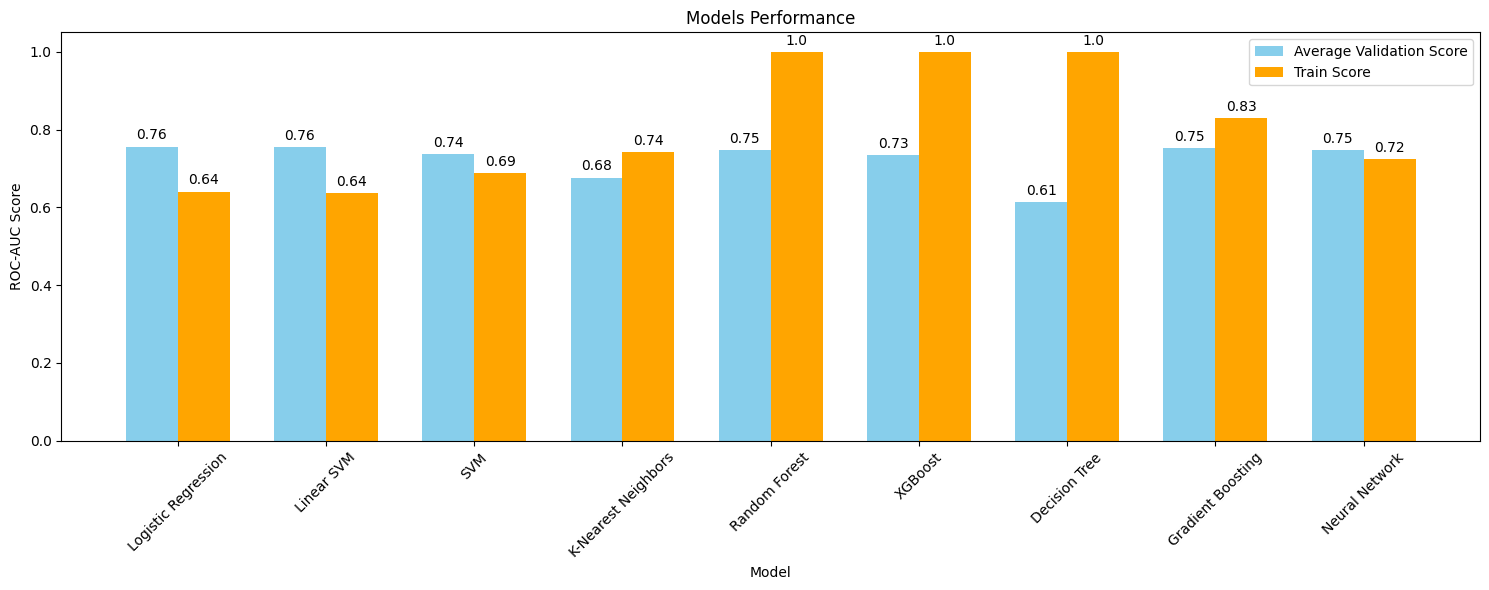

In [ ]:
eval_df = evaluate_models_cv(models=models, X_train=X_train_prepared, y_train=y_train)

In [ ]:
eval_df.sort_values(['Average Val Score'], ascending=False)

,Model,Average Val Score,Train Score
0,Logistic Regression,0.756176,0.640774
1,Linear SVM,0.755692,0.637202
7,Gradient Boosting,0.751451,0.828869
8,Neural Network,0.747135,0.723810
4,Random Forest,0.746912,1.000000
2,SVM,0.737574,0.687798
5,XGBoost,0.733482,1.000000
3,K-Nearest Neighbors,0.676451,0.741369
6,Decision Tree,0.613988,1.000000


In [ ]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

search_space = {
    'n_estimators': Integer(100, 700),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_depth': Integer(2, 16),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(2, 25),
    'bootstrap': Categorical([True, False]),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'max_features': Categorical(['sqrt', 'log2', None])
}

bayesian_search = BayesSearchCV(estimator=RandomForestClassifier(), search_spaces=search_space, cv=stratified_kfold, n_iter=50, scoring='roc_auc', return_train_score=True, random_state=42)

In [ ]:
bayesian_search.fit(X_train_prepared, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(), random_state=42,
              return_train_score=True, scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'class_weight': Categorical(categories=('balanced', 'balanced_subsample'), prior=None),
                             'criterion': Categorical(...
                             'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=2, high=25, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=700, prior='uniform', transform='normalize')})

In [ ]:
print(f'The best params fund for Random Forest are: ')
bayesian_search.best_params_

The best params fund for Random Forest are: 


OrderedDict([('bootstrap', True),
             ('class_weight', 'balanced'),
             ('criterion', 'log_loss'),
             ('max_depth', 7),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 5),
             ('min_samples_split', 49),
             ('n_estimators', 445)])

In [ ]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score', 'mean_test_score',
'mean_train_score', 'param_class_weight',
'param_criterion', 'param_max_depth',
'param_min_samples_leaf', 'param_min_samples_split',
'param_n_estimators']]
bayesian_search_results.sort_values(['rank_test_score']).head(10)

,rank_test_score,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators
39,1,0.766815,0.854009,balanced,log_loss,7,5,49,445
2,2,0.766109,0.864330,balanced_subsample,gini,8,12,9,551
37,3,0.765923,0.863460,balanced,gini,8,3,45,534
35,4,0.765737,0.819278,balanced,gini,11,25,50,700
25,5,0.765662,0.819385,balanced_subsample,gini,14,25,50,700
28,6,0.765439,0.818673,balanced_subsample,entropy,13,25,34,249
46,7,0.765439,0.823019,balanced,log_loss,9,23,49,316
9,8,0.765253,0.871877,balanced_subsample,log_loss,6,8,17,192
34,9,0.765030,0.863325,balanced_subsample,gini,14,3,47,440
33,10,0.764583,0.819210,balanced_subsample,gini,11,25,50,176


In [ ]:
def evaluate_classifier(y_true, y_pred):
    '''
    Evaluate the performance of a binary classifier using various metrics and visualizations.

    '''

    try:
        # Classification report
        print(classification_report(y_true=y_true, y_pred=y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
        sns.heatmap(cm, annot = True, fmt = 'd')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Values')
        plt.ylabel('Real Values')
        plt.show()

        # ROC AUC Curve and score
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_pred)
        auc = roc_auc_score(y_true=y_true, y_score=y_pred)

        plt.figure(figsize=(5, 3))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guessing line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.show()

    except Exception as e:
        raise CustomException(e, sys)

In [ ]:
final_rf_clf = bayesian_search.best_estimator_

In [ ]:
X_test_prepared = preprocessor.transform(X_test)
X_test_prepared.shape

(200, 9)

Making predictions.

In [ ]:
final_predictions = final_rf_clf.predict(X_test_prepared)

### Evaluating the final tuned Random Forest model.

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       140
           1       0.51      0.68      0.58        60

    accuracy                           0.70       200
   macro avg       0.67      0.70      0.68       200
weighted avg       0.74      0.70      0.72       200



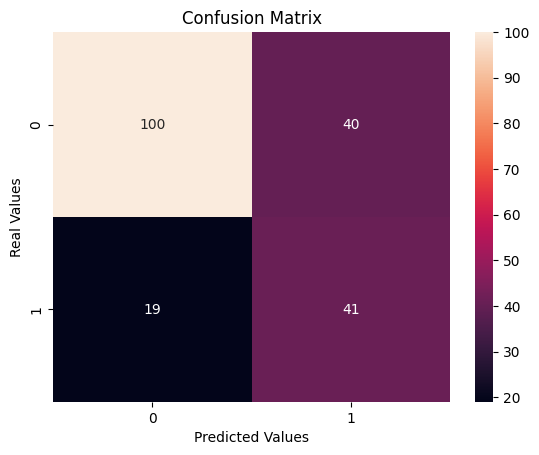

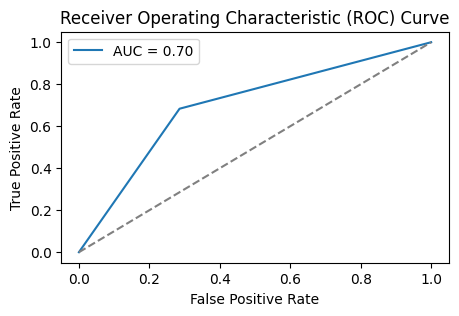

In [ ]:
evaluate_classifier(y_test, final_predictions)

In [ ]:
def plot_feature_importances(model, data):
    '''
    Plot feature importances of a given machine learning model.

    '''

    try:
        # Get feature importances
        importances = model.feature_importances_
        feature_names = data.columns


        # Sort feature importances in descending order
        indices = np.argsort(importances)[::-1]
        sorted_feature_names = [feature_names[i] for i in indices]
        sorted_importances = importances[indices]

        # Plot feature importances
        color_sequence = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']

        plt.figure(figsize=(12, 3))
        plt.title('Feature Importances')
        plt.bar(range(len(importances)), sorted_importances, tick_label=sorted_feature_names, color=color_sequence)
        plt.xticks(rotation=90)
        plt.show()

    except Exception as e:
        raise CustomException(e, sys)


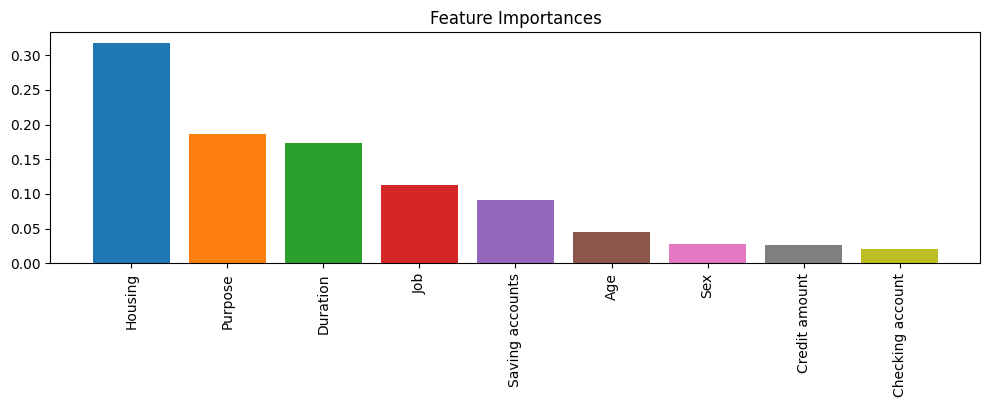

In [ ]:
plot_feature_importances(final_rf_clf, df)

In [ ]:
def precision_vs_recall_curve(y_true, predicted_probas):
    '''
    Generate a precision-recall curve based on different threshold values.

    '''

    try:
        # Obtain precision and recall values (arrays) for different threshold
        # values, when compared to the model's estimated probability of being positive.
        precision, recall, threshold = precision_recall_curve(y_true, predicted_probas[:, 1])

        # Plotting precision-recall curve.
        plt.title('Precision vs Recall Curve')
        plt.plot(threshold, precision[:-1], 'b--', label='Precision')
        plt.plot(threshold, recall[:-1], 'r--', label='Recall')
        plt.xlabel('Threshold')
        plt.legend(loc='lower left')
        plt.ylim([0,1])

        return precision, recall, threshold

    except Exception as e:
        raise CustomException(e, sys)


In [ ]:
predicted_probas = final_rf_clf.predict_proba(X_test_prepared)

Plotting precision recall curve for different threshold values.

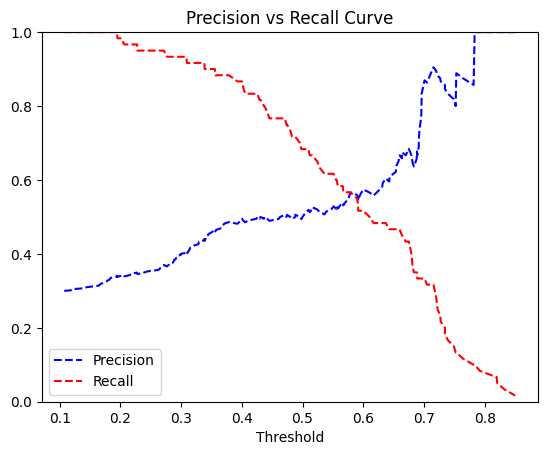

In [ ]:
precision, recall, threshold = precision_vs_recall_curve(y_test, predicted_probas)

In [ ]:
def get_threshold_metrics(precision, recall, threshold, target_metric, target_metric_value):
    '''
    Get precision and recall metrics at a specified target metric value.

    This function retrieves precision and recall metrics at a specific target
    metric value for a given threshold. It is useful for selecting thresholds
    in classification problems.

    Args:
        precision (list): A list of precision values corresponding to different thresholds.
        recall (list): A list of recall values corresponding to different thresholds.
        threshold (list): A list of threshold values.
        target_metric (str): The target metric to consider ('recall' or 'precision').
        target_metric_value (float): The desired value of the target metric.

    Returns:
        tuple: A tuple containing three elements:
            - threshold_precision (float): Precision at the specified target metric value.
            - threshold_recall (float): Recall at the specified target metric value.
            - threshold_selected (float): The threshold value corresponding to the metrics.

    Raises:
        CustomException: If an error occurs while calculating the metrics.
    '''

    try:
        if target_metric == 'recall':
            recall_array = np.asarray(recall)
            target_value_index = np.where(recall_array[:-1] == target_metric_value)[0][0]

        else:
            precision_array = np.asarray(precision)
            target_value_index = np.where(precision_array[:-1] == target_metric_value)[0][0]

        threshold_precision = precision[target_value_index]
        threshold_recall = recall[target_value_index]
        threshold_selected = threshold[target_value_index]

        print(f'For a threshold of {threshold_selected}:')
        print(f'Recall: {threshold_recall}')
        print(f'Precision: {threshold_precision}')

        return threshold_precision, threshold_recall, threshold_selected

    except Exception as e:
        raise CustomException(e, sys)

In [ ]:
def precision_vs_recall_curve(y_true, predicted_probas):
    '''
    Generate a precision-recall curve based on different threshold values.

    '''

    try:
        # Obtain precision and recall values (arrays) for different threshold
        # values, when compared to the model's estimated probability of being positive.
        precision, recall, threshold = precision_recall_curve(y_true, predicted_probas[:, 1])

        # Plotting precision-recall curve.
        plt.title('Precision vs Recall Curve')
        plt.plot(threshold, precision[:-1], 'b--', label='Precision')
        plt.plot(threshold, recall[:-1], 'r--', label='Recall')
        plt.xlabel('Threshold')
        plt.legend(loc='lower left')
        plt.ylim([0,1])

        return precision, recall, threshold

    except Exception as e:
        raise CustomException(e, sys)


In [ ]:
threshold_precision, threshold_recall, selected_threshold = get_threshold_metrics(precision=precision,
recall=recall, threshold=threshold,
target_metric='recall', target_metric_value=0.8)

For a threshold of 0.436489254149934:
Recall: 0.8
Precision: 0.4948453608247423


Making predictions.

In [ ]:
threshold_predictions = (predicted_probas[:, 1] >= selected_threshold).astype(int)

Evaluating final model after balancing the precision-recall trade-off.

              precision    recall  f1-score   support

           0       0.88      0.65      0.75       140
           1       0.49      0.80      0.61        60

    accuracy                           0.69       200
   macro avg       0.69      0.73      0.68       200
weighted avg       0.77      0.69      0.71       200



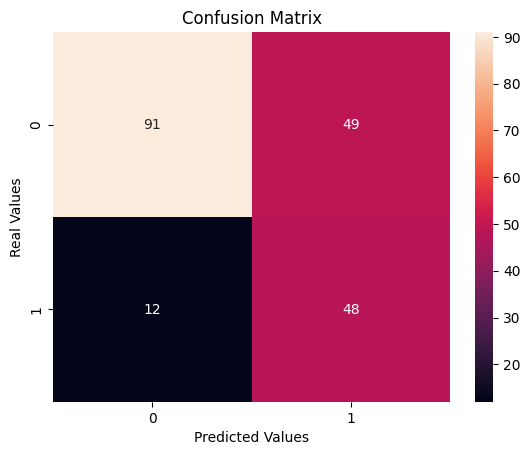

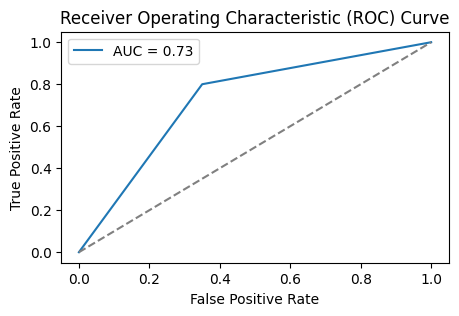

In [ ]:
evaluate_classifier(y_test, threshold_predictions)

In [ ]:
bad_risk_probas = predicted_probas[:, 1]

probas_df = pd.concat([X_test, y_test], axis=1)
probas_df['Bad Risk Probas'] = bad_risk_probas
probas_df.sort_values(['Bad Risk Probas'], ascending=False).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
887,23,1,2,own,little,moderate,15672,48,business,1,0.850249
832,29,1,2,rent,little,little,11816,45,business,1,0.832613
915,32,0,3,own,little,moderate,18424,48,vacation/others,1,0.820662
11,24,0,2,rent,little,little,4308,48,business,1,0.819681
375,37,0,2,rent,little,little,7685,48,business,1,0.792197
522,53,1,2,free,little,little,7119,48,furniture/equipment,1,0.783493
818,43,1,3,own,little,little,15857,36,vacation/others,0,0.781772
831,23,0,2,rent,little,little,1216,18,car,1,0.764318
998,23,1,2,free,little,little,1845,45,radio/TV,1,0.753262
395,32,1,2,rent,moderate,moderate,11760,39,education,0,0.752229


Top 10 customers with lowest model's estimated probabilities of being bad risk.

In [ ]:
probas_df.sort_values(['Bad Risk Probas'], ascending=True).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
551,45,1,1,own,quite rich,NaN,1750,6,radio/TV,0,0.107497
234,42,1,1,own,little,NaN,1544,4,radio/TV,0,0.118768
473,36,1,3,own,NaN,NaN,1238,6,education,0,0.118890
159,34,1,1,own,NaN,NaN,1898,6,radio/TV,0,0.119989
682,33,1,2,own,little,NaN,1478,15,radio/TV,0,0.133679
947,38,1,3,own,NaN,NaN,2859,12,car,0,0.140632
219,64,0,2,own,little,NaN,1364,10,car,0,0.142018
283,63,1,2,own,NaN,NaN,1520,15,furniture/equipment,0,0.149073
379,52,0,1,own,moderate,NaN,362,6,car,0,0.155857
725,41,0,1,own,rich,NaN,250,6,car,0,0.164666
